# Soil Structural Data Comparison

This notebook simply compares several different sets of soil structural data, clarifying how they can be used and noting their imperfections.

To run an integrated hydrology simulation, we need at least:

* porosity
* permeability
* van Genuchten or other WRM, typically generated from Rosetta from texture data + bulk density
* soil structural model (e.g. formations + horizons or other layering strategy)

For a structural model, we typically define two or three layers:  bedrock, a geologic layer, and (sometimes) a soil layer.  For the horizontal component, it is most convenient to work with formations -- horizontal shapes whose bodies are assumed to be homogeneous within the shape and layer.  We can work with fields of porosity and permeability, but currently ATS does not support fields of van Genuchten parameters, and running Rosetta at every pixel seems excessive anyway.  So we prefer to avoid doing that.


In [1]:
%matplotlib inline

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import shapely
import fiona

import watershed_workflow
import watershed_workflow.plot
import watershed_workflow.crs
import watershed_workflow.ui
import watershed_workflow.condition

from watershed_workflow.sources.manager_nhd import FileManagerNHDPlus
from watershed_workflow.sources.manager_glhymps import FileManagerGLHYMPS
from watershed_workflow.sources.manager_soilgrids_2017 import FileManagerSoilGrids2017
from watershed_workflow.sources.manager_nrcs import FileManagerNRCS
from watershed_workflow.sources.manager_pelletier_dtb import FileManagerPelletierDTB

watershed_workflow.ui.setup_logging(1)


In [3]:
# user input -- choose the HUC to work on
huc = '140200010204'
crs = watershed_workflow.crs.default_crs()

In [4]:
# collect the HUC from NHDPlus
_, watershed = watershed_workflow.get_huc(FileManagerNHDPlus(), huc, crs)
print(watershed.bounds)

2024-07-18 13:45:03,796 - root - INFO: 
2024-07-18 13:45:03,796 - root - INFO: Loading HUC 140200010204
2024-07-18 13:45:03,796 - root - INFO: ------------------------------
2024-07-18 13:45:03,797 - root - INFO: 
2024-07-18 13:45:03,797 - root - INFO: Loading level 12 HUCs in 140200010204
2024-07-18 13:45:03,797 - root - INFO: ------------------------------
2024-07-18 13:45:03,798 - root - INFO: Using HUC file "/home/ecoon/code/watershed_workflow/data/hydrography/NHDPlus_H_1402_GDB/NHDPlus_H_1402.gdb"
2024-07-18 13:45:03,837 - root - INFO: ... found 1 HUCs
2024-07-18 13:45:03,838 - root - INFO:   -- 140200010204
2024-07-18 13:45:03,838 - root - INFO: Converting to out_crs
2024-07-18 13:45:03,840 - root - INFO: Converting to shapely
2024-07-18 13:45:03,840 - root - INFO:  ... done
2024-07-18 13:45:03,840 - root - INFO: ... found 1


(-952551.1064785909, 1811083.338138938, -941371.5911273701, 1818385.785252285)


/home/ecoon/code/miniforge3/envs/watershed-workflow-master-20240507/lib/python3.10/site-packages/pyproj/crs/crs.py:1286: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/ecoon/code/miniforge3/envs/watershed-workflow-master-20240507/lib/python3.10/site-packages/pyproj/crs/crs.py:1286: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


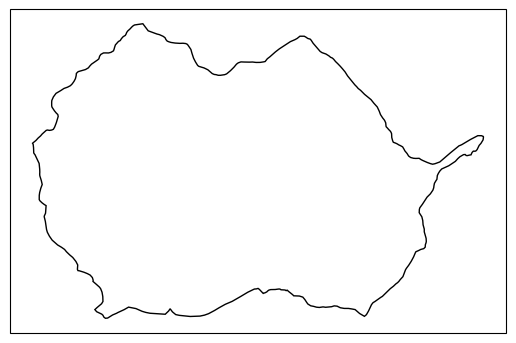

In [5]:
# plot what we have so far -- an image of the HUC
fig, ax = watershed_workflow.plot.get_ax(crs)
watershed_workflow.plot.shply(watershed, crs, ax=ax, color='k', linewidth=1)

## Available Products

The following products are routinely available across the US (or globally).

### GLHYMPS

The Global Hydrogeology Maps product provides data by shapefile/formation, and provides:

* porosity
* permeability
* depth-to-bedrock

This dataset is fairly complete, but there are some oddities -- most notably much of the DTB field seems to be 0, and a significant subset of the porosity are 0 (mostly clays, we threshold at 1% to avoid this).  But the data is pretty good and complete.  However, it is missing WRM parameters (or equivalently, texture information).

In [6]:
# first let's look at GLYHMPS
# -- get the data
gl = FileManagerGLHYMPS()
gl_crs, gl_shps, gl_props = watershed_workflow.get_shapes(gl, watershed.bounds, crs, crs, properties=True)

gl_props.set_index('id', inplace=True, drop=False)
gl_ids = np.array([shp.properties['id'] for shp in gl_shps], np.int32)
print(gl_ids)

print(len(gl_shps), len(gl_ids))

# -- color a raster by the polygons (this makes identifying a triangle's value much 
#    more efficient)
gl_color_profile, gl_color_raster = \
            watershed_workflow.color_raster_from_shapes(gl_shps, gl_crs, gl_ids, 
                                                        watershed.bounds, 10, crs, -1)                                                        

# -- print extent of properties
gl_logK = np.log10(gl_props['permeability [m^2]'][:])
print('logK', gl_logK.min(), gl_logK.max())

poro = gl_props['porosity [-]']
print('poro', poro.min(), poro.max())


2024-07-18 13:45:03,968 - root - INFO: 
2024-07-18 13:45:03,969 - root - INFO: Loading shapes
2024-07-18 13:45:03,969 - root - INFO: ------------------------------
2024-07-18 13:45:03,969 - root - INFO: Getting shapes of GLHYMPS on bounds: (-952551.1064785909, 1811083.338138938, -941371.5911273701, 1818385.785252285)
2024-07-18 13:45:03,969 - root - INFO:   from file: /home/ecoon/code/watershed_workflow/data/soil_structure/GLHYMPS/GLHYMPS.shp
/home/ecoon/code/miniforge3/envs/watershed-workflow-master-20240507/lib/python3.10/site-packages/pyproj/crs/crs.py:1286: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
2024-07-18 13:45:05,956 - root - INFO: ... found 19 shapes
2024-07-18 13:45:05,957 - root - INFO: Converting to shapely
2024-07-18 13:45:05,962 - root - INFO:  ... don

[715383 715639 715707 715766 715779 715796 715833 726508 726604 726608
 726639 726642 726650 726664 726667 726671 726678 726681 730801]
19 19
logK -15.2 -10.52
poro 0.01 0.22


Text(0.5, 1.0, 'GLHMPS')

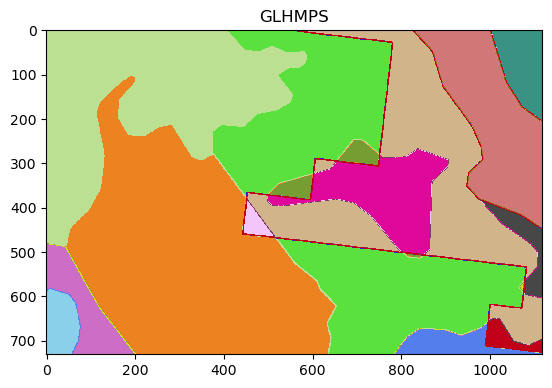

In [7]:
# plot the formations
plt.figure()
unique_inds, gl_cmap, gl_norm, gl_ticks, gl_labels = \
       watershed_workflow.colors.generate_indexed_colormap(gl_ids)


plt.imshow(gl_color_raster, cmap=gl_cmap, norm=gl_norm)
plt.title("GLHMPS")

In [8]:
# generate glhymps porosity, permeability fields
# -- create a profile
gl_profile = gl_color_profile.copy()
gl_profile['nodata'] = np.nan
gl_profile['dtype'] = 'double'

# -- porosity
gl_poro = np.nan * np.ones_like(gl_color_raster)
for str_id in gl_props.index:
    gl_poro[gl_color_raster == str_id] = gl_props.loc[str_id,'porosity [-]']
    
# -- permeability
gl_perm = np.nan * np.ones_like(gl_color_raster)
for str_id in gl_props.index:
    gl_perm[gl_color_raster == str_id] = gl_props.loc[str_id,'permeability [m^2]']


/home/ecoon/code/miniforge3/envs/watershed-workflow-master-20240507/lib/python3.10/site-packages/pyproj/crs/crs.py:1286: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
2024-07-18 13:45:06,260 - root - INFO: BOUNDS: (-952556.0, 1811081.0, -941366.0, 1818391.0)
/home/ecoon/code/miniforge3/envs/watershed-workflow-master-20240507/lib/python3.10/site-packages/pyproj/crs/crs.py:1286: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/ecoon/code/miniforge3/envs/watershed-workflow-master-20240507/lib/python3.10/site-packages/pyproj/crs/crs.py:1286: UserWarning: Yo

Text(0.5, 1.0, 'log permeability [m^2]')

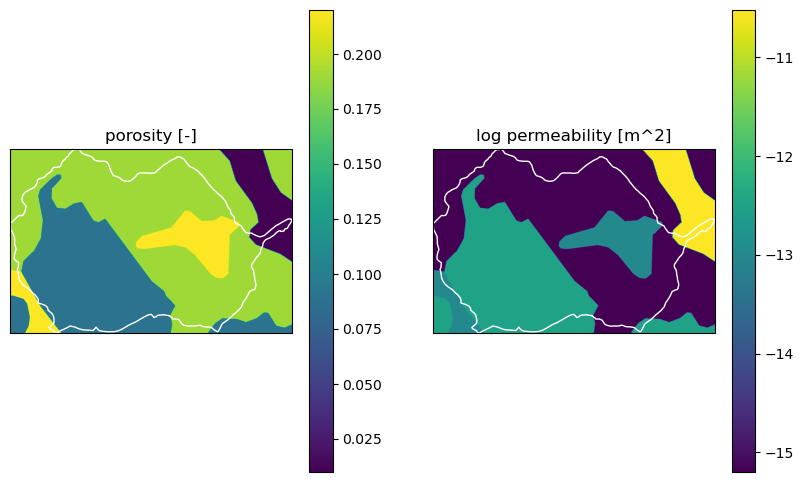

In [9]:
# plot porosity and perm for glhymps
fig, ax = watershed_workflow.plot.get_ax(crs, nrow=1, ncol=2, index=1, figsize=(10,6))
cb = watershed_workflow.plot.raster(gl_profile, gl_poro, ax)
watershed_workflow.plot.shply(watershed, crs, 'w', ax)
fig.colorbar(cb, ax=ax)
ax.set_title('porosity [-]')

ax = watershed_workflow.plot.get_ax(crs, fig=fig, nrow=1, ncol=2, index=2)
cb = watershed_workflow.plot.raster(gl_profile, np.log10(gl_perm), ax)
watershed_workflow.plot.shply(watershed, crs, 'w', ax)
fig.colorbar(cb, ax=ax)
ax.set_title('log permeability [m^2]')

### Pelletier et al (2016)

In Pelletier et al 2016, a global depth-to-bedrock raster was developed.  This has provided a reliable source for data about deep bedrock.

Pelletier, Jon D., et al. "A gridded global data set of soil, intact regolith, and sedimentary deposit thicknesses for regional and global land surface modeling." Journal of Advances in Modeling Earth Systems 8.1 (2016): 41-65.


In [10]:
pell = FileManagerPelletierDTB()
pell_profile, pell_raster = watershed_workflow.get_raster_on_shape(pell, watershed, crs, crs, 
                            mask=True, nodata=-1)

# note we have two nodata values now, the one from the fill value outside of the watershed (-1) 
# and the one from the missing gaps (pell_profile['nodata'])
print(pell_raster)

2024-07-18 13:45:06,565 - root - INFO: 
2024-07-18 13:45:06,566 - root - INFO: Loading Raster
2024-07-18 13:45:06,566 - root - INFO: ------------------------------
2024-07-18 13:45:06,567 - root - INFO: Collecting raster
2024-07-18 13:45:06,567 - root - INFO: Getting raster of Pelletier DTB on bounds: (-952551.1064785909, 1811083.338138938, -941371.5911273701, 1818385.785252285)
2024-07-18 13:45:06,568 - root - INFO:   from file: /home/ecoon/code/watershed_workflow/data/soil_structure/PelletierDTB/Global_Soil_Regolith_Sediment_1304/data/average_soil_and_sedimentary-deposit_thickness.tif
2024-07-18 13:45:06,578 - root - INFO: bounds in my_crs: (-107.10634327439818, 38.827702882440015, -106.9773610485567, 38.8947750073359)
2024-07-18 13:45:06,579 - root - INFO:   Got DTB [m]: mean = 1.2, max = 5
2024-07-18 13:45:06,580 - root - INFO:   Got DTB [m]: mean = 1.2, max = 5.0
2024-07-18 13:45:06,580 - root - INFO: ... got raster of shape: (9, 16)
2024-07-18 13:45:06,584 - root - INFO: Warping 

[[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
 [-1. -1. -1. -1.  0.  0. -1. -1. -1.  0. -1. -1. -1. -1. -1. -1.]
 [-1. -1.  2.  1.  0.  0.  0.  0.  1.  1.  1. -1. -1. -1. -1. -1.]
 [-1. -1.  0.  1.  0.  0.  0.  1.  1.  1.  0.  0. -1. -1. -1. -1.]
 [-1.  1.  0.  0.  1.  0.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1.]
 [-1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1.]
 [-1. -1.  1.  1.  0.  0.  0.  0.  0.  1.  1.  1.  0. -1. -1. -1.]
 [-1. -1. -1.  0.  0.  0.  1.  1. -1.  1.  1.  0. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]]


/home/ecoon/code/miniforge3/envs/watershed-workflow-master-20240507/lib/python3.10/site-packages/pyproj/crs/crs.py:1286: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
2024-07-18 13:45:06,685 - root - INFO: BOUNDS: (-953234.4352050158, 1810127.753073912, -940845.7665473907, 1819419.254567131)
/home/ecoon/code/miniforge3/envs/watershed-workflow-master-20240507/lib/python3.10/site-packages/pyproj/crs/crs.py:1286: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/ecoon/code/miniforge3/envs/watershed-workflow-master-20240507/lib/python3.10/site-packages/pypro

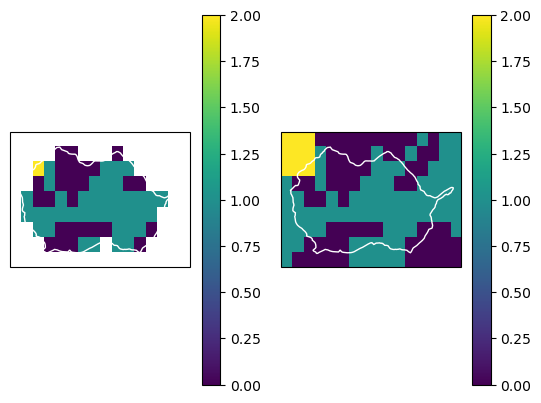

In [11]:
# plot Pelletier DTB
# -- get a temp raster to make external (-1) and nodata the same color
pell_raster2 = pell_raster.copy()
pell_raster2[pell_raster == -1] = pell_profile['nodata']

fig, ax = watershed_workflow.plot.get_ax(crs, nrow=1, ncol=2, index=1)
cb = watershed_workflow.plot.raster(pell_profile, pell_raster2, ax)
watershed_workflow.plot.shply(watershed, crs, 'w', ax)
fig.colorbar(cb, ax=ax)

pell_raster2 = watershed_workflow.condition.fill_gaps(pell_raster, nodata=pell_profile['nodata'])

pell_profile['nodata'] = -1
ax = watershed_workflow.plot.get_ax(crs, fig, nrow=1, ncol=2, index=2)
cb = watershed_workflow.plot.raster(pell_profile, pell_raster2, ax)
watershed_workflow.plot.shply(watershed, crs, 'w', ax)
fig.colorbar(cb, ax=ax)


### SSURGO

The NRCS's SSURGO/STATSGO products provide shape-based information about the top 2m of soil.  This data is provided by formation, and includes multiple formations (map-units), in which each map unit has (potentially) multiple components and each component has (potentially) multiple horizons.  Short of taking the most prevelant component, we must average, so we tend to average horizons and components and just apply this uniformly in the top 2m.  Provided include a complete set of parameters:

* porosity
* permeability
* bulk density
* texture
* and more...

Unfortunately, while map units seem to cover the area of interest, they don't all have at least one horizon with valid data, so some formations end up with NaN values.  So while SSURGO can be used as an "overlay" with good soil layer information, it cannot be used alone without a gap-filling plan.

In [12]:
# ssurgo
ss = FileManagerNRCS()
ss_crs, ss_shps, ss_props = watershed_workflow.get_shapes(ss, watershed, crs, crs, properties=True)


2024-07-18 13:45:06,862 - root - INFO: 
2024-07-18 13:45:06,863 - root - INFO: Loading shapes
2024-07-18 13:45:06,864 - root - INFO: ------------------------------
2024-07-18 13:45:06,878 - root - INFO: Attempting to download source for target '/home/ecoon/code/watershed_workflow/data/soil_structure/SSURGO/SSURGO_-107.1105_38.8257_-106.9712_38.9022.shp'
2024-07-18 13:45:06,888 - root - INFO:   Found 141 shapes.
2024-07-18 13:45:06,889 - root - INFO:   and crs: EPSG:4326
2024-07-18 13:45:06,889 - root - INFO:   Downloaded 141 total shapes
2024-07-18 13:45:06,889 - root - INFO:   Downloaded 40 unique mukeys
2024-07-18 13:45:06,915 - root - INFO: found 40 unique MUKEYs.
2024-07-18 13:45:07,546 - root - INFO: Running Rosetta for van Genutchen parameters
2024-07-18 13:45:07,599 - root - INFO:   ... done
2024-07-18 13:45:07,600 - root - INFO:   requested 34 values
2024-07-18 13:45:07,601 - root - INFO:   got 34 responses
2024-07-18 13:45:07,606 - root - INFO: ... found 40 shapes
2024-07-18 1

In [13]:
# porosity
poro = np.array([ss_props[ss_props['mukey']==shp.properties['mukey']]['porosity [-]'] for shp in ss_shps])[:,0]
rosetta_poro = np.array([ss_props[ss_props['mukey']==shp.properties['mukey']]['Rosetta porosity [-]'] for shp in ss_shps])[:,0]

/home/ecoon/code/miniforge3/envs/watershed-workflow-master-20240507/lib/python3.10/site-packages/pyproj/crs/crs.py:1286: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/ecoon/code/miniforge3/envs/watershed-workflow-master-20240507/lib/python3.10/site-packages/pyproj/crs/crs.py:1286: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/ecoon/code/miniforge3/envs/watershed-workflow-master-20240507/lib/python3.10/site-packages/pyproj/crs/crs.py:1286: UserWarning: You will likely lose important projection information when converting to a PROJ string from an

kwargs =  {}
setting face color =  [0.26556338 0.5        0.12430556 0.12430556 0.15973684 0.15973684
 0.18598639 0.18598639 0.21776316 0.40321839 0.42877868        nan
        nan        nan 0.2374226  0.27163012        nan 0.18223781
        nan        nan 0.19334978 0.31460994 0.15125    0.21862464
 0.18643963 0.31972136        nan 0.39939578 0.39939578 0.50782533
 0.44975238 0.42523026 0.41942504 0.48067568        nan 0.42720404
 0.41524481        nan 0.47685628        nan]
kwargs =  {}
setting face color =  [0.50288199 0.46665627 0.38855332 0.38855332 0.39999287 0.39999287
 0.42898954 0.42898954 0.49142853 0.46666266 0.56773973 0.37836463
 0.37836463 0.36988572 0.44516813 0.47410124 0.35616318 0.41230641
        nan        nan 0.40476462 0.4340183  0.42060792 0.46769638
 0.48273765 0.48144982        nan 0.3565054  0.3565054  0.44620526
 0.40049878 0.37827795 0.37016728 0.44773455        nan 0.37298791
 0.38313019        nan 0.44480257        nan]


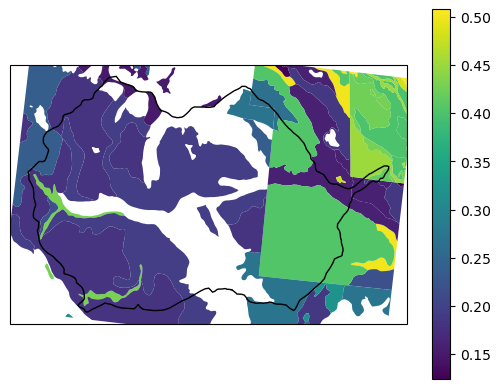

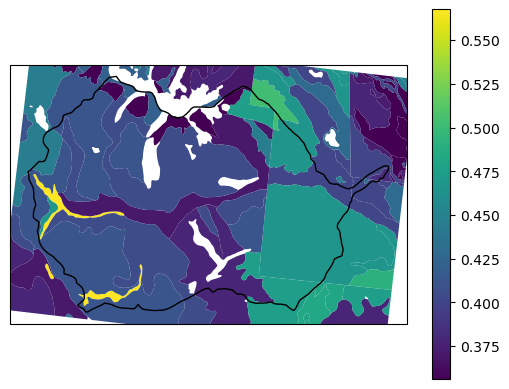

In [14]:
# plot ssurgo porosity, note white inside the domain is NaN values
fig, ax = watershed_workflow.plot.get_ax(crs)

cb = watershed_workflow.plot.shplys(ss_shps, crs, poro, ax, facecolor='color')
#watershed_workflow.plot.shplys(ss_shps, crs, 'r', ax)
watershed_workflow.plot.shply(watershed, crs, 'k', ax)
fig.colorbar(cb)
ax.relim()

fig, ax = watershed_workflow.plot.get_ax(crs)

cb = watershed_workflow.plot.shplys(ss_shps, crs, rosetta_poro, ax, facecolor='color')
#watershed_workflow.plot.shplys(ss_shps, crs, 'r', ax)
watershed_workflow.plot.shply(watershed, crs, 'k', ax)
fig.colorbar(cb)
ax.relim()


In [15]:
# permeability
perm = np.array([ss_props[ss_props['mukey']==shp.properties['mukey']]['permeability [m^2]'] for shp in ss_shps])[:,0]
rosetta_perm = np.array([ss_props[ss_props['mukey']==shp.properties['mukey']]['Rosetta permeability [m^2]'] for shp in ss_shps])[:,0]

/home/ecoon/code/miniforge3/envs/watershed-workflow-master-20240507/lib/python3.10/site-packages/pyproj/crs/crs.py:1286: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


kwargs =  {}
setting face color =  [-12.64211113 -12.08888504 -10.61352188 -10.61352188 -11.56318872
 -11.56318872 -11.92657887 -11.92657887 -12.73936284 -12.13477879
 -11.5172557  -11.49860996 -11.49860996 -11.33210948 -12.03990221
 -12.62424079 -11.2327742  -11.81625135 -14.15490196 -10.37358777
 -11.69755308 -12.09610817 -12.1246855  -12.79839071 -12.75739236
 -12.81900276          nan -11.27425238 -11.27425238 -12.42477007
 -11.27883023 -11.89053782 -11.91999592 -12.52287875          nan
 -11.60135264 -11.80852371          nan -12.21372873          nan]
kwargs =  {}
setting face color =  [-12.4415548  -12.49108037 -11.34408166 -11.34408166 -12.30639314
 -12.30639314 -12.5481126  -12.5481126  -12.51605903 -12.42217024
 -11.61286392 -12.98643793 -12.98643793 -12.8313613  -12.5642633
 -12.61347227 -12.64571195 -12.52782663          nan          nan
 -12.44160698 -12.68227575 -12.59920191 -12.68009915 -12.58296905
 -12.60746043          nan -12.25263868 -12.25263868 -12.6200875
 -11.74

/home/ecoon/code/miniforge3/envs/watershed-workflow-master-20240507/lib/python3.10/site-packages/pyproj/crs/crs.py:1286: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/ecoon/code/miniforge3/envs/watershed-workflow-master-20240507/lib/python3.10/site-packages/pyproj/crs/crs.py:1286: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/ecoon/code/miniforge3/envs/watershed-workflow-master-20240507/lib/python3.10/site-packages/pyproj/crs/crs.py:1286: UserWarning: You will likely lose important projection information when converting to a PROJ string from an

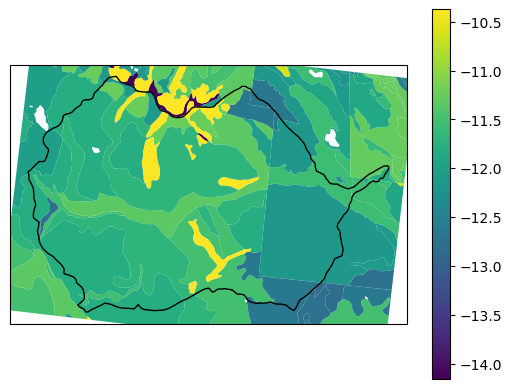

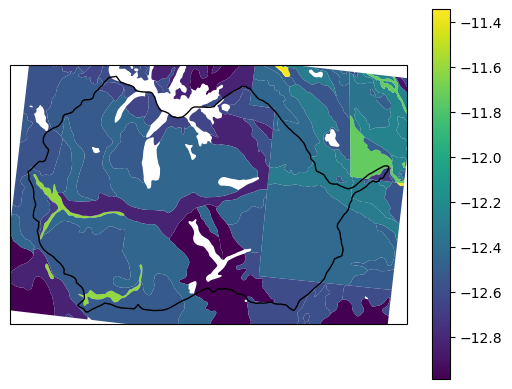

In [16]:
# plot ssurgo perm, note white inside the domain is NaN values
fig, ax = watershed_workflow.plot.get_ax(crs)

cb = watershed_workflow.plot.shplys(ss_shps, crs, np.log10(perm), ax, facecolor='color')
#watershed_workflow.plot.shplys(ss_shps, crs, 'r', ax)
watershed_workflow.plot.shply(watershed, crs, 'k', ax)
fig.colorbar(cb)
ax.relim()

fig, ax = watershed_workflow.plot.get_ax(crs)

cb = watershed_workflow.plot.shplys(ss_shps, crs, np.log10(rosetta_perm), ax, facecolor='color')
#watershed_workflow.plot.shplys(ss_shps, crs, 'r', ax)
watershed_workflow.plot.shply(watershed, crs, 'k', ax)
fig.colorbar(cb)
ax.relim()


### SoilGrids (2017)

SoilGrids includes 250m, global rasters of:

* depth to bedrock
* bulk density
* texture via percent sand/silt/clay
* and more...

Effectively everything is available that is needed to run Rosetta to get a full suite of parameters.  Vertically, bulk density and texture information are provided at 7 layers, the deepest starting at 2m.  Data is complete globally, and doesn't seem to have much missing data except under water bodies.  The only downside is the raster nature of the data -- to use this directly we would have to run every pixel through Rosetta and provide fields of Van Genuchten parameters.  We could conceivably use the rasters of porosity and permeability, but it seems more convenient to work by formation instead of as a raster.

Note that here we use the 2017 product instead of the 2020 product as that has yet to include depth-to-bedrock.  The depth-to-bedrock here seems fairly inaccurate -- generally we have stopped using SoilGrids for this reason.

In [17]:
# SoilGrids
#
# NOTE: this may not work any more -- we may need to deprecate SoilGrids.
sg = FileManagerSoilGrids2017()
sg_profile, sg_raster = watershed_workflow.get_raster_on_shape(sg, watershed, crs, crs, 
                            mask=True, nodata=-1, variable='BDTICM')

# for some reason soilgrid's nodata doesn't match the actual value in the raster?
print(sg_profile['nodata'], sg_raster.min())
sg_profile['nodata'] = -32769

# note we have two nodata values now, the one from the fill value outside of the watershed (-1) 
# and the one from the missing gaps (sg_profile['nodata'])
print(sg_raster)

2024-07-18 13:45:08,229 - root - INFO: 
2024-07-18 13:45:08,229 - root - INFO: Loading Raster
2024-07-18 13:45:08,229 - root - INFO: ------------------------------
2024-07-18 13:45:08,230 - root - INFO: Collecting raster
2024-07-18 13:45:08,231 - rasterio._env - INFO: GDAL signalled an error: err_no=1, msg='/home/ecoon/code/watershed_workflow/data/soil_structure/SoilGrids2017/BDTICM_M_250m_ll.tif: TIFFFetchDirectory:/home/ecoon/code/watershed_workflow/data/soil_structure/SoilGrids2017/BDTICM_M_250m_ll.tif: Can not read TIFF directory count'
2024-07-18 13:45:08,231 - rasterio._env - INFO: GDAL signalled an error: err_no=1, msg='/home/ecoon/code/watershed_workflow/data/soil_structure/SoilGrids2017/BDTICM_M_250m_ll.tif: TIFFReadDirectory:Failed to read directory at offset 8479362622'


RasterioIOError: /home/ecoon/code/watershed_workflow/data/soil_structure/SoilGrids2017/BDTICM_M_250m_ll.tif: TIFFReadDirectory:Failed to read directory at offset 8479362622

SoilGrids has holes where there is standing water, but we still need soil in these places.  Fill these using a nearest neighbor algorithm.

In [ ]:
# plot SoilGrids DTB
# -- get a temp raster to make external (-1) and nodata the same color
sg_raster2 = sg_raster.copy()
sg_raster2[sg_raster == -1] = sg_profile['nodata']

fig, ax = watershed_workflow.plot.get_ax(crs, nrow=1, ncol=2, index=1)
cb = watershed_workflow.plot.raster(sg_profile, sg_raster2, ax)
watershed_workflow.plot.shply(watershed, crs, 'w', ax)
fig.colorbar(cb, ax=ax)

sg_raster2 = watershed_workflow.condition.fill_gaps(sg_raster, nodata=sg_profile['nodata'])

sg_profile['nodata'] = -1
ax = watershed_workflow.plot.get_ax(crs, fig, nrow=1, ncol=2, index=2)
cb = watershed_workflow.plot.raster(sg_profile, sg_raster2, ax)
watershed_workflow.plot.shply(watershed, crs, 'w', ax)
fig.colorbar(cb, ax=ax)
